<font size = 3>
<h1 align="center">
IMPORTING PACKAGES

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv 

<font size = 3>
<h1 align="center">
IMPORTING DATA

In [2]:
# Ordner inputten lassen?
# Ausgabe is dann csv file und dict (_acq) mit infos

<font size = 3>
<h1 align="center">
SEPERATING AND FILLING HEADER AND DATA SECTION

In [3]:

def create_dataframe(file_path):
    """
    Reads in a csv file and creates a header and a data section

    Args:
        file_path (str): a relative or abolute pathway to the file, which contains the whole information

    Returns:
        header_section (list): list with each line of the header as an entry
        data_section_raw (dataframe): pandas dataframe of the data section

    """

    with open(file_path, 'r') as csv_file:
        data = csv.reader(csv_file, delimiter=',')

        header_section = []
        column_names = ["ID","Frame index","Groups","Donor Photons","Acceptor Photons","FRET efficiency","X (nm)","Y (nm)"]
        #nicht so sauber
        data_section_raw = pd.DataFrame(columns = column_names)

        #for row in data:
            #print(row)

        for n, row in enumerate(data):
            if n < 15:
            #das mit 15 ist unsauber
                header_section.append(row)
            elif n == 15:
                continue
            elif row == ['', '', '', '', '', '', '', '']:
                continue
            else:
                new_row=[]
                for element in row:
                        try:
                            new_row.append(float(element))
                        except ValueError:
                            new_row.append(0)

                data_section_raw.loc[n]=new_row

    return header_section, data_section_raw



<font size = 3>
<h1 align="center">
ADJUSTING DATAFRAME ACCORDING TO GLOBAL PARAMETERS

In [4]:
def adjust_dataframe_global(data_section, global_parameters_dict, local_parameters_path):
    """
    Turns the raw data into plottable FRET data regarding global parameters

    Args:
        data_section_raw (dataframe): a raw dataframe containing the to be adjusted data
        global_parameters_dict (dict): contains the global adjusting parameters {frames_per_second: (float)}

    Returns:
        data_section (dataframe): the adjusted dataframe
    """

    #GLOBAL PARAMETERS ----------------------------------------------------------------------------------------------------------------------------------------

    # X: Frames zu seconds (PARAMETER und später aus file)
    # Y: Photon counts zu Frequenz (Counts/s)

    data_section = data_section.rename(columns={'Frame index': 'Time', 'Donor Photons': 'Frequency Donor', 'Acceptor Photons': 'Frequency Acceptor'})

    frames_per_second = global_parameters_dict["frames_per_second"]


    for row in range(len(data_section)):

        data_section.iloc[row]["Time"] = float(data_section.iloc[row]["Time"]) / frames_per_second

        try:
            data_section.iloc[row]["Frequency Donor"] = float(data_section.iloc[row]["Frequency Donor"]) / frames_per_second
        except ZeroDivisionError:
            data_section.iloc[row]["Frequency Donor"] = 0

        try:
            data_section.iloc[row]["Frequency Acceptor"] = float(data_section.iloc[row]["Frequency Acceptor"]) / frames_per_second
        except ZeroDivisionError:
            data_section.iloc[row]["Frequency Acceptor"] = 0

    # Creating the Local Parameter CSV File ---------------------------------------------------------------------------------

    ID_set = set()

    for row in range(len(data_section)):
        ID_set.add(int(data_section.iloc[row]["ID"]))

    ID_dict = {}

    for ID in ID_set:
        ID_dict[ID] = {"Group" : 2, "Bin" : 3, "Bleach range" : 50, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}
        
    df_ID_dict = pd.DataFrame.from_dict(ID_dict, orient='index')
    #df_ID_dict = pd.DataFrame.from_dict([ID_dict]) 

    df_ID_dict.to_csv (r'local_parameters.csv', header=True)

    return data_section


<font size = 3>
<h1 align="center">
ADJUSTING DATAFRAME ACCORDING TO LOCAL PARAMETERS

In [5]:
def adjust_dataframe_local(data_section, local_parameters_path):
    """
    Turns the raw data into plottable FRET data regarding local parameters

    Args:
        data_section_raw (dataframe): a raw dataframe containing the to be adjusted data
        global_parameters_dict (dict): contains the global adjusting parameters {frames_per_second: (float)}
        local_parameters_dict (dict): contains the adjusting parameteres for every ID {IDX:[Group, Bin, Bleach, Blink]}

    Returns:
        data_section (dataframe): the adjusted, ready to print dataframe
    """

    # LOCAL PARAMETERS --------------------------------------------------------------------------------------------------------------------------------------

    # Filtern nach Gruppen ermöglichen und Gruppeninfo mittragen als Variable (Visualisierung!)
    # Gleitender durchschnitt (PARAMETER!) - mal 3-5 frames breit
    # Individueller Cutoff für Bleaching und Blinking

    column_names = ["ID","Time","Groups","Frequency Donor","Frequency Acceptor","FRET efficiency","X (nm)","Y (nm)"]
    #nicht so sauber
    data_section_new = pd.DataFrame(columns = column_names)
    
    ID_set = set()

    for row in range(len(data_section)):
        ID_set.add(int(data_section.iloc[row]["ID"]))


    local_parameters_dict = dict()
    local_parameters_csv = open(local_parameters_path)

    for counter, line in enumerate(local_parameters_csv):

        if counter == 0:
            continue

        line = line. strip('\n')
        ID, Group,  Bin,  Bleach_range,  Bleach_ratio,  Blink,  Additional_cutoff = line.split(",")
        local_parameters_dict[int(ID)] = {"Group": int(Group), "Bin" : int(Bin), "Bleach range" : int(Bleach_range), "Bleach ratio" : int(Bleach_ratio), "Blink" : int(Blink), "Additional cutoff" : int(Additional_cutoff)}

    # BLEACHING ---------------------------------------------------------------------------------------------------------------

    #iter_data_section = data_section.copy()

    output_data_section = data_section.copy()  

    for current_ID in ID_set:

        iter_data_section = data_section.copy()

        # Der übergeordnete Loop ist zwar umständlich (alle Reihen für jede ID),
        # aber sonst ist es schwierig den row Loop zu beenden wenn Zeilen gelöscht wurden
        
        bleaching_range = local_parameters_dict[current_ID]["Bleach range"]
        bleaching_ratio = local_parameters_dict[current_ID]["Bleach ratio"]
        additional_cutoff = local_parameters_dict[current_ID]["Additional cutoff"]


        bleaching_counter = 0

        for row in range(len(iter_data_section)):

            if iter_data_section.iloc[row]["ID"] != current_ID:
                continue            

            if iter_data_section.iloc[row]["Frequency Donor"] > iter_data_section.iloc[row]["Frequency Acceptor"] * bleaching_ratio:
                bleaching_counter = bleaching_counter + 1
            
            if bleaching_counter >= bleaching_range:

                print("__________________________________________________________________________________")
                print(f"current row: {row}")
                print(f"current ID: {current_ID}")

                #Characterising to be deleted rows in iteration df:

                # Indices_of_ID = iter_data_section[iter_data_section['ID'] == current_ID].index.tolist()
                # last_row = Indices_of_ID[-1] - 16
                # #Das ist hässlich, aber er kommt durcheinander weil die ersten 15 Indices nicht besetzt sind (Header section)
                # print(f"indices of ID, last row: {last_row}")

                # to_be_removed_time_start = iter_data_section.iloc[row]["Time"]
                # print(f"Time to be removed start: {to_be_removed_time_start}")
                # to_be_removed_time_end = iter_data_section.iloc[last_row]["Time"]
                # print(f"Time to be removed end: {to_be_removed_time_end}")  

                #to_be_removed_time_start = iter_data_section.iloc[row]["Time"]
                to_be_removed_time_start = iter_data_section.iloc[row - bleaching_range - additional_cutoff]["Time"]
                print(f"Time to be removed start: {to_be_removed_time_start}")
                to_be_removed_time_end = iter_data_section[iter_data_section.ID == current_ID]["Time"].max()
                print(f"Time to be removed end: {to_be_removed_time_end}")
                #BIS HIER PASSTS, DIE ZEITEN STIMMEN!

                #Delting equivalent rows in original dataframe:

                # first_row_org_df = data_section[data_section.ID == current_ID][data_section["Time"] == to_be_removed_time_start].index.tolist()
                # print(f"first row index = {first_row_org_df[0]}")
                # last_row_org_df = data_section[data_section.ID ==current_ID][data_section["Time"] == to_be_removed_time_end].index.tolist()
                # print(f"last row index = {last_row_org_df[0]}")
                # #WRONG


                # first_row_org_df = data_section[data_section.ID == current_ID & data_section["Time"] == to_be_removed_time_start].index.tolist()
                # print(f"first row index = {first_row_org_df[0]}")
                # last_row_org_df = data_section[data_section.ID ==current_ID & data_section["Time"] == to_be_removed_time_end].index.tolist()
                # print(f"last row index = {last_row_org_df[0]}")
                # #WRONG

                data_section_ID = data_section[data_section.ID == current_ID]
                first_row_org_df = data_section_ID[data_section_ID["Time"] == to_be_removed_time_start].index.tolist()
                print(f"first row index = {first_row_org_df[0]}")
                last_row_org_df = data_section_ID[data_section_ID["Time"] == to_be_removed_time_end].index.tolist()
                print(f"last row index = {last_row_org_df[0]}")
                #WRONG

                output_data_section["Frequency Donor"][first_row_org_df[0] : last_row_org_df[0]] = 0
                output_data_section["Frequency Acceptor"][first_row_org_df[0] : last_row_org_df[0]] = 0

                #data_section = data_section.drop(data_section.index[first_row_org_df[0]:last_row_org_df[0]], axis=0)


                #data_section = data_section[data_section.ID == current_ID[data_section["Time"] <= to_be_removed_time_start]]
                #data_section[data_section.ID == current_ID] = data_section[data_section.ID == current_ID][data_section["Time"] <= to_be_removed_time_start]

                print(f"Bleaching happended at ID = {current_ID}, time start = {to_be_removed_time_start} and time end = {to_be_removed_time_end}")
                
                break

    # Blinking ----------------------------------------------------------------------------------------------------------------------------------------------


    #iter_data_section = data_section.copy()

    for current_ID in ID_set:

        iter_data_section = data_section.copy()

        # Der übergeordnete Loop ist zwar umständlich (alle Reihen für jede ID),
        # aber sonst ist es schwierig den row Loop zu beenden wenn Zeilen gelöscht wurden

        blinking_value = local_parameters_dict[current_ID]["Blink"]
        additional_cutoff = local_parameters_dict[current_ID]["Additional cutoff"]

        for row in range(len(iter_data_section)):

            if iter_data_section.iloc[row]["ID"] != current_ID:
                continue

            if iter_data_section.iloc[row]["Frequency Acceptor"] != 0:
                continue

            list_of_values = []

            for line in range(blinking_value):
                if iter_data_section.iloc[row + line].ID == current_ID:
                    list_of_values.append(iter_data_section.iloc[row+line]["Frequency Acceptor"])
                else:
                    continue

                # try:
                #     list_of_values.append(data_section[data_section.ID == current_ID].iloc[row+line]["Frequency Acceptor"])
                # except IndexError:
                #     continue
            
            if all([ values == 0.0 for values in list_of_values]) and list_of_values != [] and len(list_of_values) == blinking_value:

                print("__________________________________________________________________________________")
                print(f"current row: {row}")
                print(f"current ID: {current_ID}")
                print(f"list of values: {list_of_values}")

                #Characterising to be deleted rows in iteration df:

                # Indices_of_ID = iter_data_section[iter_data_section['ID'] == current_ID].index.tolist()
                # last_row = Indices_of_ID[-1] - 16
                # #Das ist hässlich, aber er kommt durcheinander weil die ersten 15 Indices nicht besetzt sind (Header section)
                # print(f"indices of ID, last row: {last_row}")

                # to_be_removed_time_start = iter_data_section.iloc[row]["Time"]
                # print(f"Time to be removed start: {to_be_removed_time_start}")
                # to_be_removed_time_end = iter_data_section.iloc[last_row]["Time"]
                # print(f"Time to be removed end: {to_be_removed_time_end}") 

                to_be_removed_time_start = iter_data_section.iloc[row-additional_cutoff]["Time"]
                print(f"Time to be removed start: {to_be_removed_time_start}")
                to_be_removed_time_end = iter_data_section[iter_data_section.ID == current_ID]["Time"].max()
                print(f"Time to be removed end: {to_be_removed_time_end}") 



                #Delting equivalent rows in original dataframe:

                # first_row_org_df = data_section[data_section['ID']==current_ID][data_section["Time"] == to_be_removed_time_start].index.tolist()
                # print(f"first row index = {first_row_org_df[0]}")
                # last_row_org_df = data_section[data_section['ID']==current_ID][data_section["Time"] == to_be_removed_time_end].index.tolist()
                # print(f"last row index = {last_row_org_df[0]}")
                # #WRONG

                # data_section = data_section.drop(data_section.index[first_row_org_df[0]:last_row_org_df[0]], axis=0)

                # first_row_org_df = data_section[data_section['ID']==current_ID][data_section["Time"] == to_be_removed_time_start].index.tolist()
                # print(f"first row index = {first_row_org_df[0]}")
                # last_row_org_df = data_section[data_section['ID']==current_ID][data_section["Time"] == to_be_removed_time_end].index.tolist()
                # print(f"last row index = {last_row_org_df[0]}")
                # #last_row_org_d stimmt auch!

                # first_row_org_df = data_section[data_section['ID']==current_ID & data_section["Time"] == to_be_removed_time_start].index.tolist()
                # print(f"first row index = {first_row_org_df[0]}")
                # last_row_org_df = data_section[data_section['ID']==current_ID & data_section["Time"] == to_be_removed_time_end].index.tolist()
                # print(f"last row index = {last_row_org_df[0]}")
                # #last_row_org_d stimmt auch!

                data_section_ID = output_data_section[output_data_section['ID']==current_ID]
                first_row_org_df = data_section_ID[data_section_ID["Time"] == to_be_removed_time_start].index.tolist()
                print(f"first row index = {first_row_org_df[0]}")
                last_row_org_df = data_section_ID[data_section_ID["Time"] == to_be_removed_time_end].index.tolist()
                print(f"last row index = {last_row_org_df[0]}")
                #last_row_org_d stimmt auch!


                #"Frequency Donor","Frequency Acceptor",
                output_data_section["Frequency Donor"][first_row_org_df[0] : last_row_org_df[0]] = 0
                output_data_section["Frequency Acceptor"][first_row_org_df[0] : last_row_org_df[0]] = 0


                #data_section = data_section.drop(data_section.index[first_row_org_df[0]:last_row_org_df[0]], axis=0)

                #data_section = data_section[data_section.ID == current_ID[data_section["Time"] <= to_be_removed_time_start]]
                #data_section[data_section.ID == current_ID] = data_section[data_section.ID == current_ID][data_section["Time"] <= to_be_removed_time_start]

                #df = df[df['Team'] != 'C']

                print(f"Blinking happended at ID = {current_ID}, time start = {to_be_removed_time_start} and time end = {to_be_removed_time_end}")

                break
            

    # BINNING -----------------------------------------------------------------------------------------------------------------------------------------------
    
    row_number = 0
    counter = 0

    for row in range(len(output_data_section)):
        
        current_ID = int(output_data_section.iloc[row]["ID"])
        bin = local_parameters_dict[current_ID]["Bin"]


        if counter % bin == 0 and current_ID == output_data_section.iloc[row]["ID"]:

            data_bin = output_data_section.iloc[counter : counter + bin]
            #print(data_bin)

            data_means = data_bin.mean(axis=0)

            if data_means["ID"] != data_bin["ID"].iloc[0]:
                #row_number = row_number + 1
                counter = counter +1
                continue
            #Inhomogener Bin wird hier verworfen


            data_section_new.loc[row_number] = ["","","","","","","",""]

            data_section_new.iloc[row_number]["ID"] = data_means["ID"]
            data_section_new.iloc[row_number]["Time"] = data_means["Time"]
            data_section_new.iloc[row_number]["Groups"] = data_means["Groups"]
            data_section_new.iloc[row_number]["Frequency Donor"] = data_means["Frequency Donor"]
            data_section_new.iloc[row_number]["Frequency Acceptor"] = data_means["Frequency Acceptor"]
            data_section_new.iloc[row_number]["FRET efficiency"] = data_means["FRET efficiency"]
            data_section_new.iloc[row_number]["X (nm)"] = data_means["X (nm)"]
            data_section_new.iloc[row_number]["Y (nm)"] = data_means["Y (nm)"]

            row_number = row_number + 1
            counter = counter +1

        else: counter = counter +1

    return data_section_new

<font size = 3>
<h1 align="center">
VISUALIZING DATA VIA SUBPLOTS

In [6]:
def plot_dataframe(data_section_global_and_local, data_section_global, local_parameters_path ,group_dict):
    """
    Prints the dataframe, which one subplot per ID

    Args:
        data_section_global_and_local (dataframe): Contains the globally and locally adjusted, to be plotted data
        data_section_global (dataframe): Contains the to globally adjusted, to be plotted data
        local_parameters_dict (dict): Binning, Bleaching and Blinking Parameters for plot description
        group_dict (dict): Contains the references for groups for the plot description

    Returns:
        None
    """

    # Collecting occuring ID Values

    ID_set = set()

    for row in range(len(data_section_global)):
        ID_set.add(int(data_section_global.iloc[row]["ID"]))

    print(f'ID_set: {ID_set}')

    # How many are there?

    amount_IDs = len(ID_set)
    print(f'There are {amount_IDs} different IDs')


    # Building the Parameters Dict

    local_parameters_dict = dict()
    local_parameters_csv = open(local_parameters_path)

    for counter, line in enumerate(local_parameters_csv):

        if counter == 0:
            continue

        line = line. strip('\n')
        ID, Group,  Bin,  Bleach_range,  Bleach_ratio,  Blink,  Additional_cutoff = line.split(",")
        local_parameters_dict[int(ID)] = {"Group": int(Group), "Bin" : int(Bin), "Bleach range" : int(Bleach_range), "Bleach ratio" : int(Bleach_ratio), "Blink" : int(Blink), "Additional cutoff" : int(Additional_cutoff)}

    # For each ID make one subplot!

    fig, axes = plt.subplots(amount_IDs, 2, figsize=(25, amount_IDs*7))
    fig.suptitle("smFRET", fontsize=30)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
    #fig.tight_layout(h_pad = 2)


    # axes.spines["right"].set_visible(False)
    # axes.spines["top"].set_visible(False)

    for number, element in enumerate(ID_set):

        # Print datasection global on the left side -------------------------------------------------------------------------
        
        x_values_g = []
        yD_values_g = []
        yA_values_g = []

        filtered_data_g = data_section_global.loc[data_section_global.ID == element]
    
        for line in range(len(filtered_data_g)):
            x_values_g.append(filtered_data_g.iloc[line]["Time"])
            yD_values_g.append(filtered_data_g.iloc[line]["Frequency Donor"])
            yA_values_g.append(filtered_data_g.iloc[line]["Frequency Acceptor"])

        x_limit_g = data_section_global.Time.loc[data_section_global.ID == element].max()
        x_limit_g = x_limit_g * 1.05
        y_limit_Acceptor_g = data_section_global.loc[:,"Frequency Acceptor"].loc[data_section_global.ID == element].max()
        y_limit_Donor_g = data_section_global.loc[:,"Frequency Donor"].loc[data_section_global.ID == element].max()
        y_limit_g = max([y_limit_Acceptor_g,y_limit_Donor_g])*1.2

        row_g = number
        coloum_g = 0

        axes[row_g, coloum_g].plot(x_values_g, yD_values_g, label = "Donor")
        axes[row_g, coloum_g].plot(x_values_g, yA_values_g, label = "Acceptor")
        axes[row_g, coloum_g].set_title(f"ID: {element}\nData only adjusted to fit axes")
        #axes[row_g, coloum_g].set_xticks([0,x_tick_1,x_tick_2,x_tick_3])
        axes[row_g, coloum_g].set_xlim(0,x_limit_g)
        #axes[row_g, coloum_g].set_yticks([0,y_tick_1,y_tick_2,y_tick_3])
        axes[row_g, coloum_g].set_ylim(0,y_limit_g)
        axes[row_g, coloum_g].legend()
        #axes[row, coloum].xticks(rotation=45)
        axes[row_g, coloum_g].set_axisbelow(True)
        #axes[row_g, coloum_g].grid()


        # Print datasection global and local on the right side  -------------------------------------------------------------

        group_of_ID = local_parameters_dict[element]["Group"]
        group_name = group_dict[group_of_ID]

        binsize = local_parameters_dict[element]["Bin"]
        bleach_ratio = local_parameters_dict[element]["Bleach ratio"]
        bleach_range = local_parameters_dict[element]["Bleach range"]
        blink = local_parameters_dict[element]["Blink"]

        #print(f'\n ID: {element}:')

        # shortcut = files_to_compare[f"Plot {number + 1}"]
        # x_values, y_values, unit_1, unit_2 = data_for_subplot (shortcut[0], 
        #     shortcut[1], countries, shortcut[2])

        x_values_g_l = []
        yD_values_g_l = []
        yA_values_g_l = []

        filtered_data_g_l = data_section_global_and_local.loc[data_section_global_and_local.ID == element]
    
        for line in range(len(filtered_data_g_l)):

            # if filtered_data_g_l.iloc[line+1 : line+20]["Frequency Donor"].all() == 0:
            #     if filtered_data_g_l.iloc[line]["Frequency Donor"] != 0:
            #         last_value_time = filtered_data_g_l.iloc[line]["Time"]

            x_values_g_l.append(filtered_data_g_l.iloc[line]["Time"])
            yD_values_g_l.append(filtered_data_g_l.iloc[line]["Frequency Donor"])
            yA_values_g_l.append(filtered_data_g_l.iloc[line]["Frequency Acceptor"])

        x_limit_g_l = data_section_global_and_local.Time.loc[data_section_global_and_local.ID == element][data_section_global_and_local["Frequency Donor"] != 0].max()
        x_limit_g_l = x_limit_g_l *1.2
        y_limit_Acceptor_g_l = data_section_global_and_local.loc[:,"Frequency Acceptor"].loc[data_section_global_and_local.ID == element].max()
        y_limit_Donor_g_l = data_section_global_and_local.loc[:,"Frequency Donor"].loc[data_section_global_and_local.ID == element].max()
        y_limit_g_l = max([y_limit_Acceptor_g_l,y_limit_Donor_g_l])*1.2

        row_g_l = number
        coloum_g_l = 1

        axes[row_g_l, coloum_g_l].plot(x_values_g_l, yD_values_g_l, label = "Donor")
        axes[row_g_l, coloum_g_l].plot(x_values_g_l, yA_values_g_l, label = "Aceptor")
        axes[row_g_l, coloum_g_l].set_title(f"ID: {element}\nGroup: {group_name}, Binsize: {binsize} frames\nCutoffs - Bleaching range:{bleach_range} frames, Bleaching ratio: {bleach_ratio}, Blinking:{blink} frames")
        #axes[row_g_l, coloum_g_l].set_xticks([0,x_tick_1,x_tick_2,x_tick_3])
        axes[row_g_l, coloum_g_l].set_xlim(0,x_limit_g_l)
        #axes[row_g_l, coloum_g_l].set_yticks([0,y_tick_1,y_tick_2,y_tick_3])
        axes[row_g_l, coloum_g_l].set_ylim(0,y_limit_g_l)
        axes[row_g_l, coloum_g_l].legend()
        #axes[row, coloum].xticks(rotation=45)
        axes[row_g_l, coloum_g_l].set_axisbelow(True)
        #axes[row_g_l, coloum_g_l].grid()

    for axes in axes.flat:
        axes.set(xlabel='Time [s]', ylabel='Frequency [Photons/s]')
        #axes.yticks([0,200,400,600,800])
        #axes.xticks([0,200,400,600])
        axes.spines["right"].set_visible(False)
        axes.spines["top"].set_visible(False)
        #axes.spines["left"].set_visible(False)
        #axes.spines["bottom"].set_visible(False)

    #fig.legend(ID_set, ncol = len(ID_set))

<font size = 3>
<h1 align="center">
RUN CODE

__________________________________________________________________________________
current row: 1579
current ID: 355
Time to be removed start: 17.44
Time to be removed end: 23.8
first row index = 1544
last row index = 1703
Bleaching happended at ID = 355, time start = 17.44 and time end = 23.8
__________________________________________________________________________________
current row: 3670
current ID: 457
Time to be removed start: 19.8
Time to be removed end: 23.36
first row index = 3635
last row index = 3724
Bleaching happended at ID = 457, time start = 19.8 and time end = 23.36
__________________________________________________________________________________
current row: 964
current ID: 143
Time to be removed start: 2.24
Time to be removed end: 9.4
first row index = 929
last row index = 1108
Bleaching happended at ID = 143, time start = 2.24 and time end = 9.4
__________________________________________________________________________________
current row: 2695
current ID: 438
Time

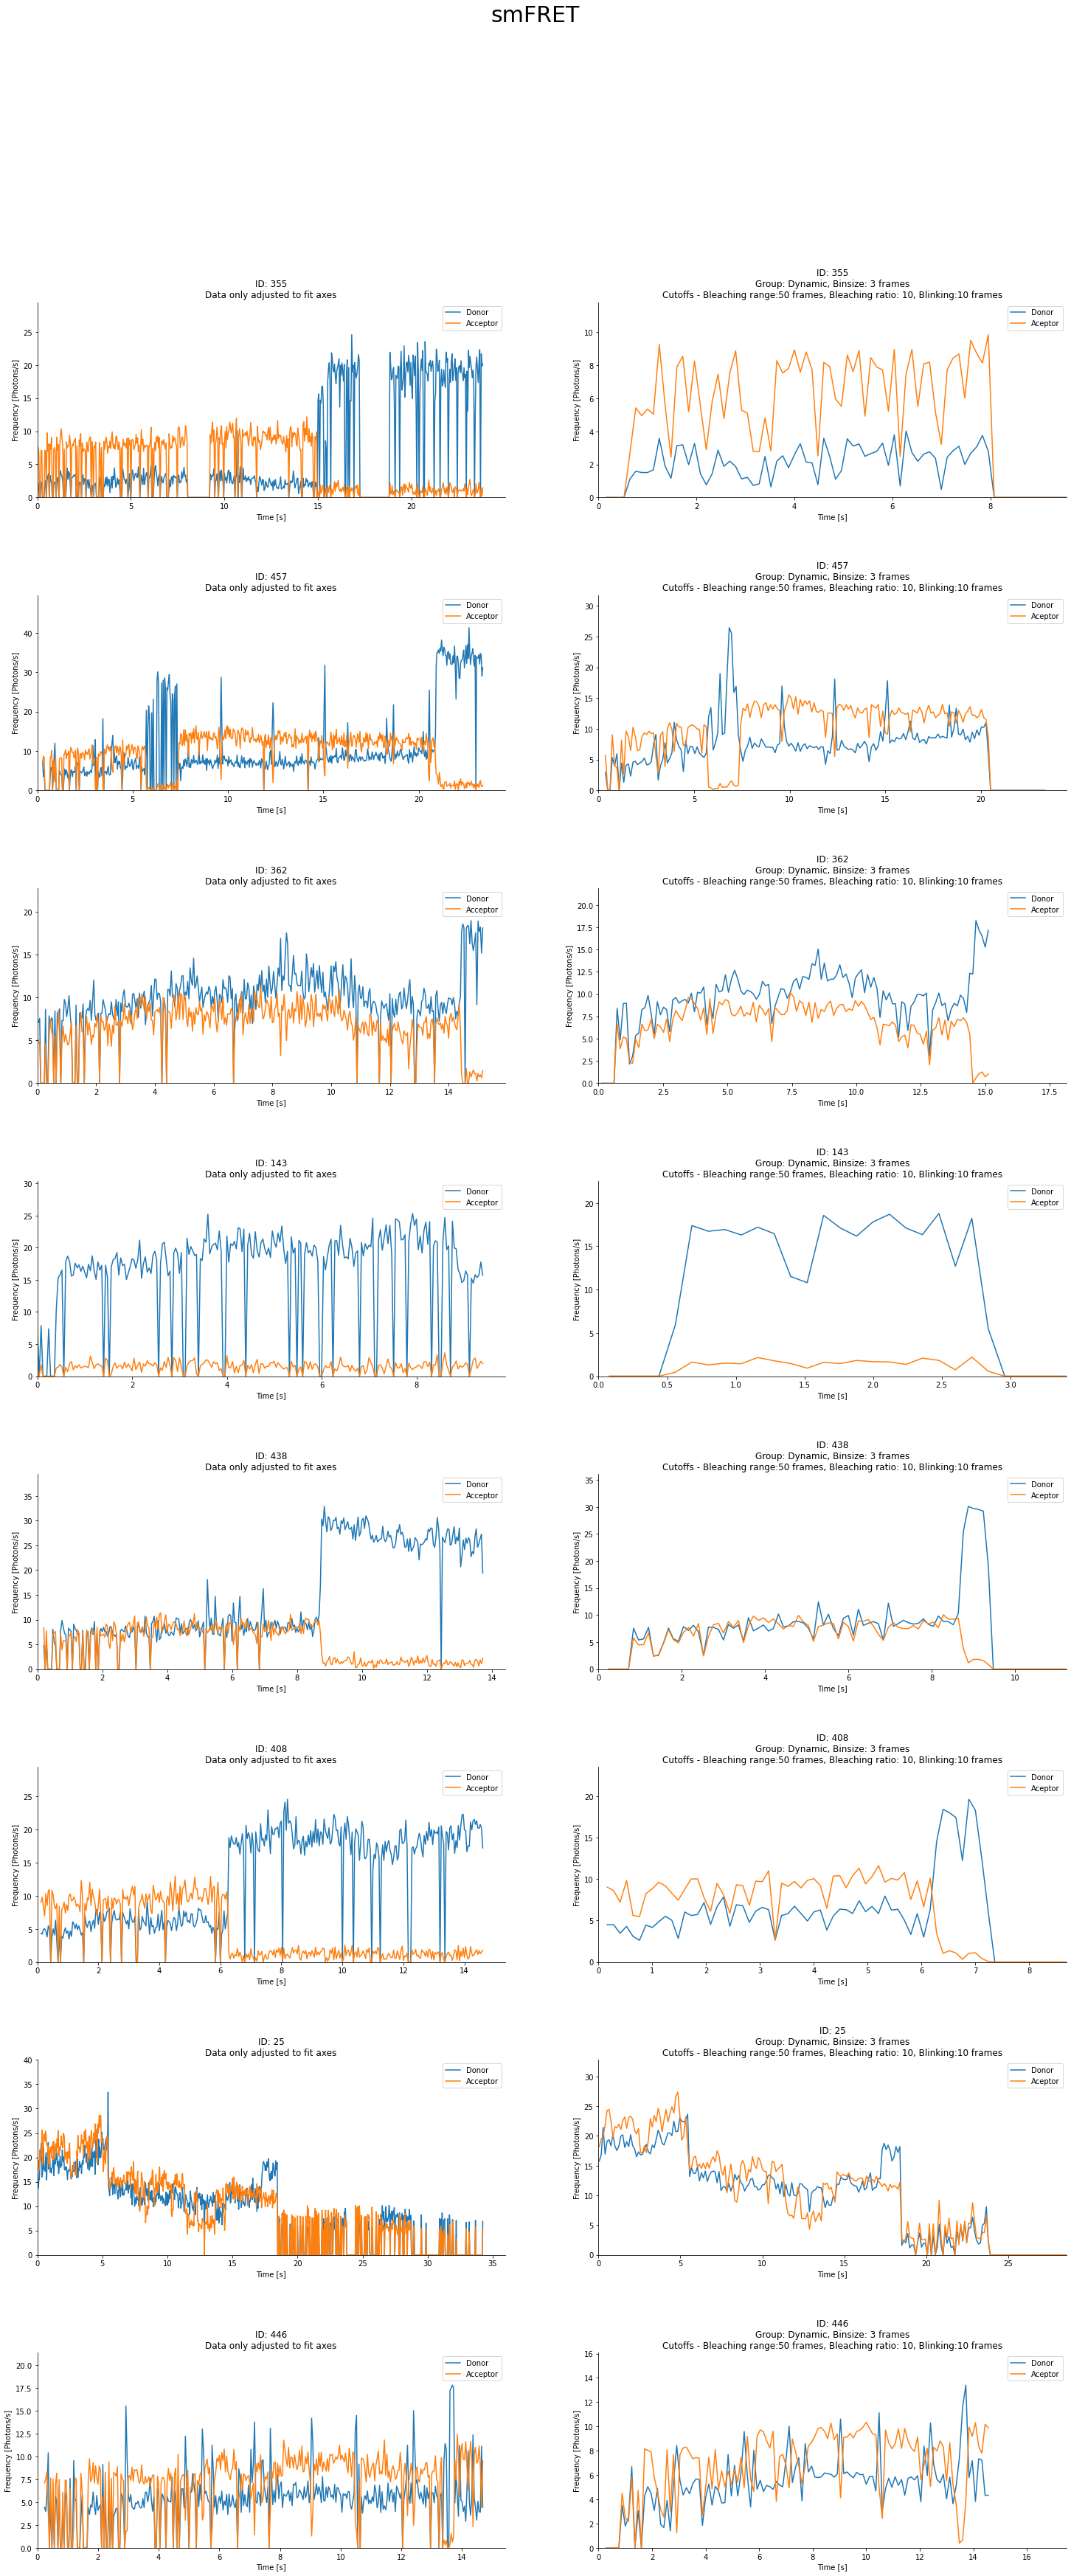

In [7]:
#filepath = "./dsDNA_FRETtraces_examples_MK.csv"
filepath = "./dsDNA_FRETtraces_examples_MK_bearbeitet2.csv"

header_section, data_section_raw = create_dataframe(filepath)

# print("\nHEADER:")
# print(header_section)

# print("_________________________________________")

# print("\nDATA:")
# print(data_section_raw)


global_parameters_dict = {"frames_per_second": 25}

local_parameters_path = "local_parameters.csv"

# local_parameters_dict = {   408   : {"Group" : 2, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1},
#                             25    : {"Group" : 2, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1},
#                             457   : {"Group" : 2, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}, 
#                             446   : {"Group" : 2, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}, 
#                             143   : {"Group" : 3, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}, 
#                             355   : {"Group" : 2, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}, 
#                             362   : {"Group" : 4, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}, 
#                             438   : {"Group" : 2, "Bin" : 3, "Bleach range" : 100, "Bleach ratio": 10 , "Blink" : 10, "Additional cutoff" : 1}}

#Bin wird noch intern angegeben!

data_section_global = adjust_dataframe_global(data_section_raw, global_parameters_dict, local_parameters_path)

#Parameter CSV wurde ersetllt und kann hier bearbeitet werden!

data_section_global_and_local = adjust_dataframe_local(data_section_global, local_parameters_path)

# print("\nDATA:")
# print(data_section)

group_dict = { "" : "No Group assigned",
    0 : "Trash",
    1 : "Static",
    2 : "Dynamic",
    3 : "Donor only",
    4 : "Acceptor only",
    5 : "Aggregates",
    6 : "empty",
    7 : "empty",
    8 : "empty",
    9 : "others"}


plot_dataframe(data_section_global_and_local,  data_section_global,  local_parameters_path, group_dict)
